# COMP90051 Project 2

In [2]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [3]:
class MAB(ABC):
    
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB):
    
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        # valueQ list to store the estimate value of each arm as average reward, initial to inf
        self.valueQ = [Q0 for i in range(narms)]
        # count list to store how many times we play the arms, initial to zero
        self.count = np.zeros(narms)   
 

    def play(self, tround, context=None):
        # we exploit when random number is greater than epsilon, otherwise we explore
        if np.random.random() > self.epsilon:
            # exploitation: find maximum value list and randomly select an arm from it
            values = self.valueQ
            nextArmList = []
            for index, value in enumerate(values):
                if value == max(values):
                    nextArmList.append(index)
            # tie-breaking
            nextArm = int(np.random.choice(nextArmList))
        else:
            # exploration: random choose next arm
            nextArm = np.random.randint(self.narms)
        nextArm = nextArm + 1  # index is from 0, so add 1 to be the arm number
        return nextArm      
        
        
    def update(self, arm, reward, context=None):
        index = arm - 1  # index is from 0, so subtract 1 from the arm number
        currentQ = self.valueQ[index]
        # if arm not explored, change the reward value to zero
        if currentQ == np.inf:
            currentQ = 0     
        self.count[index] = self.count[index] + 1
        currentC = self.count[index]
        # update the estimate value with previous weighted average value + new reward 
        self.valueQ[index] = (currentQ * (currentC - 1) + reward) / currentC
        

In [6]:
class UCB(MAB):
    
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.Q0 = Q0
        self.narms = narms
        self.rho = rho
        # count list to store how many times we play each arm, initial to zero
        self.count = np.zeros(narms)
        # average value list to store the average amount of reward of each arm, initial to inf
        self.avgList = [Q0 for i in range(narms)]
        # valueQ list to store the estimate value of each arm
        self.valueQ = [Q0 for i in range(narms)]
        
        
    def play(self, tround, context=None):
        self.tround = tround
        values = self.valueQ
        nextArmList = []
        for index, value in enumerate(values):
            if value == max(values):
                nextArmList.append(index + 1)  # index is from 0, so add 1 to be the arm number
        # tie-breaking
        nextArm = int(np.random.choice(nextArmList))
        return nextArm
        
        
    def update(self, arm, reward, context=None):
        index = arm - 1  # index is from 0, so subtract 1 from the arm number
        average = self.avgList[index]
        # if arm not explored, change the reward value to zero
        if average == np.inf:
            average = 0     
        self.count[index] = self.count[index] + 1
        currentC = self.count[index]
        # update the average value with previous weighted average value + new reward 
        self.avgList[index] = (average * (currentC - 1) + reward) / currentC
        # update extimate Q value of each chosen arm
        for i in range(self.narms):
            mean = self.avgList[i]
            if mean != np.inf:  # update Q value for the arms that have been explored
                self.valueQ[i] = mean + np.sqrt((self.rho * np.log(self.tround)) / self.count[i])
 

## 2. Off-Policy Evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    recordId = 0
    rewardList = []
    
    for t in range(1, nrounds + 1):
        # get next event
        armPredicted = mab.play(t, contexts[recordId])
        # find same arm as the one that was selected by logging policy
        while armPredicted != arms[recordId]:
            recordId += 1
            armPredicted = mab.play(t, contexts[recordId])
        # retain the event 
        mab.update(armPredicted, rewards[recordId], contexts[recordId])
        # store the rewards in a list to evaluate the result
        rewardList.append(rewards[recordId])
        recordId += 1

    return rewardList
    

In [8]:
# Load the data file
data = np.loadtxt('dataset.txt')
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:]

In [ ]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

In [10]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.14875


## 3. Contextual Bandits

In [11]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.Aa = {}
        self.ba = {}
        self.p = np.zeros(narms)
        # initialize matrix and vector list for every arms
        for index in range(narms):
            # ndims*ndims 
            self.Aa[index] = np.identity(ndims)
            # ndims*1 
            self.ba[index] = np.zeros((ndims, 1))

        
    def play(self, tround, context):
        # reshape the context from 100*1 to 10*10 matrix
        reshapedContext = context.reshape(self.narms, self.ndims)
        nextArmList = []
        # calculate p value for each arms
        for index in range(self.narms):
            xaT = reshapedContext[index]
            xa = np.transpose([xaT])
            theta = np.dot(np.linalg.inv(self.Aa[index]), self.ba[index])
            self.p[index] = np.dot(xaT, theta) + self.alpha * np.sqrt(np.dot(np.dot(xaT, np.linalg.inv(self.Aa[index])), xa))
        # find the arms with maximum p value
        for index, value in enumerate(self.p):
            if value == max(self.p):
                nextArmList.append(index)
        # tie-breaking
        nextArm = int(np.random.choice(nextArmList)) + 1
        return nextArm
    
    
    def update(self, arm, reward, context):
        index = arm - 1
        reshapedContext = context.reshape(self.narms, self.ndims)
        feature = np.array(reshapedContext[index])
        # change feature from (!0,) to (1,10)
        feature = feature[np.newaxis,:]
        featureT = np.transpose([reshapedContext[index]])
        # update Aa and ba
        self.Aa[index] = self.Aa[index] + np.dot(featureT, feature)
        self.ba[index] = self.ba[index] + reward * np.transpose([reshapedContext[index]])


In [12]:
mab = LinUCB(10, 10, 1)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

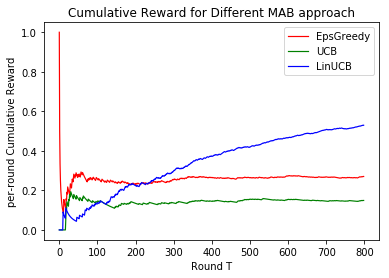

In [16]:
# initialize the dataset to print the figure
figEpsGreedy = [np.mean(results_EpsGreedy[0:t]) for t in range(1, 800)]
figUCB = [np.mean(results_UCB[0:t]) for t in range(1, 800)]
figLinUCB = [np.mean(results_LinUCB[0:t]) for t in range(1, 800)]
# use matplotlib to print the figure
plt.plot(figEpsGreedy, 'r', linewidth=1.2, label='EpsGreedy')
plt.plot(figUCB, 'g', linewidth=1.2, label='UCB')
plt.plot(figLinUCB, 'b', linewidth=1.2, label='LinUCB')
# label and title
plt.title('Cumulative Reward for Different MAB approach')
plt.xlabel('Round T')
plt.ylabel('per-round Cumulative Reward')
plt.legend()
plt.show()

### 4.B.

In [ ]:
# set x-axis, start from 0.1, step is 0.1, end to 2
alphaList = [alpha for alpha in np.arange(0, 2, 0.1)]
# set y-axis
alphaDict = dict()
for alpha in alphaList:
    alpha = round(float(alpha), 2)
    timer = 4
    t = 0
    resultList = []
    # for each mab we run three times and find mean of them
    while t < timer:
        mab = LinUCB(10, 10, alpha)
        resultSingle = offlineEvaluate(mab, arms, rewards, contexts, 800)
        resultList.append(resultSingle)
        t = t + 1
    result = np.mean(resultList)
    # store alpha, cumulative reward as the key, value in dictionary
    alphaDict.update({alpha: result})

bestAlpha = max(alphaDict, key=alphaDict.get)
print("When alpha is chosen to be %f, the cumulative reward is the largest."%(bestAlpha))

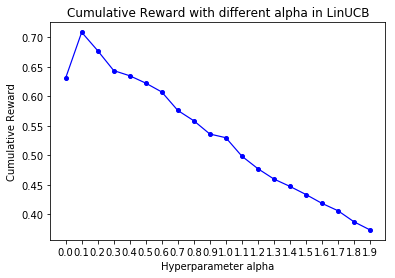

In [71]:
# plot Cumulative Reward with different alpha in LinUCB
lists = sorted(alphaDict.items())
x, y = zip(*lists)
plot = plt.plot(x, y, 'b', linewidth=1.2)
plt.plot(x, y, 'bo', markersize = 4)
myTicks = []
# set x-axis labels
myTicks = [str(round(float(alpha), 2)) for alpha in np.arange(0, 2, 0.1)]
plt.title('Cumulative Reward with different alpha in LinUCB')
plt.xlabel('Hyperparameter alpha')
plt.ylabel('Cumulative Reward')
plt.xticks(x, myTicks)
plt.show()

## 5. KernelUCB

In [94]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        self.narms = narms
        self.ndims = ndims
        # hyperparameters
        self.alpha = alpha
        self.eta = eta
        self.kern = kern
        self.u = {}
            
    def play(self, tround, context):
        # reshape the context from 100*1 to 10*10 matrix
        reshapedContext = context.reshape(self.narms, self.ndims)
        if tround == 1:
            zeroList = np.zeros(self.narms)
            zeroList[0] = 1
            self.u[tround] = np.transpose([zeroList])
        else:
            for n in range (self.narms):
                xaT = reshapedContext[n]
                xa = np.transpose([xaT])
                k = []
                K = np.dot(xaT, xa)
                k = np.transpose([k.append(rbf_kernel(xa))])
                sigma = np.sqrt(self.kern(reshapedContext[n],reshapedContext[n]) - 
                                np.dot(np.dot(np.transpose([self.kern(k)]),K),self.kern(k)))
                u[tround] = np.dot(np.transpose([self.kern(k)])
                
    
    def update(self, arm, reward, context):
        index = arm - 1
        reshapedContext = context.reshape(self.narms, self.ndims)
        feature = np.array(reshapedContext[index])
        feature = feature[np.newaxis,:]
        featureT = np.transpose([reshapedContext[index]])
        self.u[index] = self.u[index] + np.dot(featureT, feature)    
        

In [ ]:
mab = KernelUCB(10, 10, 1)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('Kernel average reward', np.mean(results_KernelUCB))